**Introduction:**

Using simple random search. In our case, the cost function is just the reach error -- calculated by the reach error between the previous lamdba values and the current one. 

Error is defined as reach error: $ error = ||t-y||^2 $ and the perturbation term $ p_{2k+1} $ can be thought of a normal distribution.

$$ FR+ = FR - \frac{\nu}{N\delta} \sum_{n = 1}^N ( error(FR + \delta p) - error(FR) ) \cdot  p, p \sim \mathcal{N}(0,\sigma^2) $$

Note: p is a perturbation taken from a distribution with mean = 0

References:

[1] G. Cauwenberghs, “A Fast Stochastic Error-Descent Algorithm for Supervised Learning and Optimization,” in Advances in Neural Information Processing Systems 5, S. J. Hanson, J. D. Cowan, and C. L. Giles, Eds. Morgan-Kaufmann, 1993, pp. 244–251.

[2] R. Héliot, K. Ganguly, J. Jimenez, and J. M. Carmena, “Learning in Closed-Loop Brain–Machine Interfaces: Modeling and Experimental Validation,” IEEE Transactions on Systems, Man, and Cybernetics, Part B (Cybernetics), vol. 40, no. 5, pp. 1387–1397, Oct. 2010, doi: 10.1109/TSMCB.2009.2036931.


In [1]:
import numpy as np
from numpy import linalg
import numpy.matlib
import matplotlib.pyplot as plt
import seaborn

seaborn.set()


### Brain Modeling

In [2]:
# Brain Model 
###################
# Function that calculates firing rate from b, W, t
# B(t) = b + [Wx Wy][tx ty]' = firing rate
# This is Equation (2.a, 2.b) in Heliot et al, 2010

## INPUT
# N = number of neurons
# lambda_vect = [b, W_x, W_y] for each neuron; N x 3
# targ_vect = 2 x 1
## OUTPUT
# newFR = N x 1
def brainFiringRate(lambda_vect, targ_vect):
    targ_vect_mult = np.insert(targ_vect.copy(), 0, 1)
    newFR = np.zeros( (np.size(lambda_vect, 0), 1) )
    newFR[:, 0] = np.matmul(lambda_vect, targ_vect_mult)
    return newFR

###################
# Function that alters the lambda paramters (b, W) for the brain
# B(t) = b + [Wx Wy][tx ty]' = firing rate
# This is Equation (6) in Heliot et al, 2010

## INPUT
# N = number of neurons
# lambda_vect = [b, W_x, W_y] for each neuron; N x 3
# delta_perturb = N x 1
# targ_vect = 2 x 1
## MIDDLE
# targ_vect_mult = 3 x 1 [1 t_x t_y]'
# targ_matx = N x 3
# delta_matx = N x 3
# next_term = delta_matx*delta_matx (element-wise mult) = N x 3
## OUTPUT
# lambda_vect_new = N x 3

def calcNextLambda(lambda_vect, gamma, delta_perturb, targ_vect):
    # This is the vector to multiply the lambda update term with = [1 t_x t_y]'
    num_neurons = np.size(lambda_vect.copy(), 0)
    targ_vect_mult = np.insert(targ_vect.copy(), 0, 1) # 3 x 1  
    targ_matx = (np.matlib.repmat(targ_vect_mult, num_neurons, 1)) # N x 3

    # next gradient term: \gamma*delta_perturb
    delta_matx = np.matlib.repmat(delta_perturb, 1, 3) # N x 3
    next_term = (delta_matx*targ_matx) # 3 x N

    lambda_vect_new = lambda_vect.copy() - (gamma*next_term)
    return lambda_vect_new


### Decoder Model

In [3]:
####################
# Decoder Model 
# Affine Function that calculates target postion from firing rate
# Y = D(f) = a + Kf --> Weiner Filter
# This is Equation (1) in Heliot et al, 2010

## INPUT
# N = number of neurons, d = dimension of target
# decoder params = current a vector and K matrix (a = d x 1, K = d x N)
# fr_curr = current firing rate as a vector
# targ_vect = target position (T_x, Y_y)
## OUTPUT
# Cursor position = Y_x, Y_y
def decoder_findY(decoder_params, brain_params):
    # check firing rate 
    # Start with affine decoder
    (a_vect_in, k_matx_in) = decoder_params
    (fr_curr, targ) = brain_params
    a_vect = a_vect_in.copy()
    k_matx = k_matx_in.copy()
    cursor_pos = np.zeros( (NUM_DIM, 1))
    cursor_pos = a_vect.reshape(NUM_DIM, 1) +  (np.matmul(k_matx, fr_curr))
#     print("in decoder_findY")
#     print(cursor_pos)
#     print(np.shape(cursor_pos))
    return (cursor_pos)

# Function uses stochastic gradient descent to adjust decoder parameters
## INPUT
# decoder params = current a vector and K matrix (a = d x 1, K = d x N)
# fr_curr = current firing rate as a vector
## OUTPUT
# next decoder parameters = a_next, k_next
def calcNextDecoder(decoder_params, brain_vars):
    (a_vect, a_rate, a_dist, k_matx, k_rate, k_dist) = decoder_params
    cost_func_args = ( (a_vect, k_matx), brain_vars)
    # a vector
    if (ADAPT_DEC == True):
        a_grad = findErrorGrad(a_vect.copy(), A_VAR, a_dist,error_costFunc, cost_func_args)
        k_grad = findErrorGrad(k_matx.copy(), K_VAR, k_dist, error_costFunc, cost_func_args)
        a_next = a_vect.copy().reshape(np.shape(a_grad)) - a_rate*a_grad
        k_next = k_matx.copy() - k_rate*k_grad
    else:
        a_next = a_vect
        k_next = k_matx

    return (a_next, k_next)

### Reach Error

In [4]:
####################
# Reach error
# This is Equation (3) in Heliot et al, 2010

## INPUT
# y_x, y_y = predicted cursor position
# t_x, t_y = target position
## OUTPUT
# norm squared of (target position - cursor position)
# where reach error is the target position - cursor position
def calcReachError(y_vect, t_vect):
    norm_vect = np.array(y_vect) - np.array(t_vect)
    return (np.linalg.norm(norm_vect, 2)**2)

## INPUT
# cost_func_params = decoder params (a vect, k matx) and current firing rate
## OUTPUT
# reach error = scalar; norm squared of (target position - cursor position)
# where reach error is the target position - cursor position
def error_costFunc(cost_func_params):
    (decoder_params, brain_vars) = cost_func_params
    (fr_curr, targ_vect) = brain_vars
    y_vect = decoder_findY(decoder_params, brain_vars)
    t_vect = targ_vect
    return calcReachError(y_vect, t_vect)  


### Stochastic Error Descent: Update Calculation

In [5]:
import random
import time


## Stochastic Error Descent
# This is Equation (4) and Equation (5) in Heliot, 2010
# Derivation is found in Cauwenberghs, 1993 

# This function is one iteration of the error descent calcuation
## INPUT
# input_vect = vector to stochastically perturb
# input_var = FR_VAR, A_VAR OR K_VAR 
# param_dist = distribution from which perturbations to the input are selected
# cost_func = cost function (always reach error)
# cost_func_args = arguments to the cost function (depends on error cost function)
## OUTPUT
# errorGrad = gradient for updating parameter (input vect)
def findErrorGrad(input_vect, input_var, param_dist, cost_func, cost_func_args):
    # Un-nest everything
    (sigma, delta, num_dist) = param_dist
    (decoder_params, (curr_fr, targ_vect) ) = cost_func_args
    (a_vect, k_matx) = decoder_params
    
    # Get size of input vector
    num_neurons = np.size(k_matx, 1)
    num_input_row = np.size(input_vect, 0) 
    num_input_column = 1
    if (input_vect.ndim > 1): 
        num_input_column = np.size(input_vect, 1)
    
    # What to perturb and input firing rate for error cost function
    input_vect = input_vect.copy().reshape(num_input_row, num_input_column)
    input_fr = curr_fr.copy().reshape(num_neurons, 1)
       
    error_sum = np.zeros((num_input_row, 1)) 
    error_grad = np.zeros((num_input_row, 1))
    perturb_rand = np.zeros((num_input_row, num_input_column, num_dist))
    
    
    for iC in range(num_input_column):
        for iN in range(num_input_row):
            random.seed(time.time())
            perturb_rand[iN, iC, :] = np.random.uniform(0, sigma, num_dist) 
            # perturb_rand = N_input x N_dist
            # for each iteration, np.random.normal returns a N_dist x 1 array
    
    for iD in range(num_dist):
        # perturb_vect = stochastic pertrbation (amount of stochastic descent perturbation)
        perturb_vect = np.squeeze(perturb_rand[:, :, [iD]])
        perturb_vect = perturb_vect.copy().reshape(num_input_row, num_input_column)
        
        # find the delta error caused by the perturbation (direction to descend gradient in) 
        input_perturb = np.add(input_vect, delta*perturb_vect) 
        
        # Case 1: firing rate
        # error = reachError(a + K*fr')
        if (input_var == FR_VAR):        
            # Calculate error 
            perturb_cost_args = (decoder_params, (input_perturb, targ_vect) ) 
            
        # case 2: a
        # error = reachError(a' + K*fr)
        elif (input_var == A_VAR):
            decoder_params_perturb = (input_perturb, k_matx)
            perturb_cost_args = (decoder_params_perturb, (input_fr, targ_vect))

        # case 3: k
        # error = reachError(a + K'*fr)
        elif (input_var == K_VAR):
            decoder_params_perturb = (a_vect, input_perturb)
            perturb_cost_args = (decoder_params_perturb, (input_fr, targ_vect))   
        
        # default: do nothing
        else:
            perturb_cost_args = cost_func_args
        
        error_perturb = cost_func(perturb_cost_args)   
        error_input = cost_func(cost_func_args)
        error_sum = np.add(error_sum, (error_perturb - error_input)*perturb_vect)

    error_grad = np.array(error_sum/(num_dist*delta))
    return error_grad



### Stochastic Gradient Descent: Update Step and Recalculate Error

In [6]:
# This function goes through and updates brain paramters over the num_iter times
def brain_adapt_sgd(brain_params, decoder_params, targ_vect, num_iter):
    (fr_init, fr_dist, lambda_init, lambda_rate) = brain_params
    (fr_init, targ_vect)= brain_vars
    (fr_sigma, fr_delta, fr_dist_size) = fr_dist
    (a_init, a_rate, a_dist, k_init, k_rate, k_dist) = decoder_params
    decoder_init = (a_init, k_init)
    grad_args_init = (decoder_init, brain_vars)
    

    num_neurons = np.size(fr_init, 0)
    runs_num = 1

    # for sigma in sigma_list:
    for iR in range(runs_num):
        # Set the u vectors
        fr_vect = np.zeros( (num_neurons, 1, num_iter) )
        fr_vect[:, :, 0] = fr_init #fr init = num_neurons x 1
#         fr_vect[:, 0] = fr_init
        fr_final = np.zeros((num_neurons, 1, runs_num))
        re_final = np.zeros(runs_num)
        lambda_final = np.zeros((num_neurons, np.size(lambda_init, 1), runs_num))

        print("starting fr vect = " + str( fr_vect[:, :, 0] ))
        # lambda init = N x 3
        # lambda_vect = N x 3 X ITER
        lambda_vect = np.zeros( (num_neurons, np.size(lambda_init, 1), num_iter))
        lambda_vect[:,:,0] = lambda_init 

        # set the cost vector
        err_vect = np.zeros(num_iter)
        err_vect[0] = error_costFunc(grad_args_init)
        print('initial error = ' + str(err_vect[0]))

        # calculate the initial delta e
        grad_new = np.zeros(num_iter)
        grad_new = findErrorGrad(fr_init, FR_VAR, fr_dist, error_costFunc, grad_args_init)

        for iT in range(num_iter-1):
            ## calculate the new u 
            # (1) lambda+ = lambda - learn_rate*grad_error; B(lambda) = f
            lambda_next = calcNextLambda(lambda_vect[:, :, iT], lambda_rate, grad_new, targ_vect)
            lambda_vect[:,:, iT + 1] = lambda_next
            
            # (2) fr+ = B(lambda+)
            fr_next = brainFiringRate(lambda_next, targ_vect)
            fr_vect[:, :, iT+1] = fr_next

            # Update parameters for calculating error and calculate the new cost
            # (3) Calculate the new reach error 
            brain_vars_next = fr_next, targ_vect
            grad_args_next = (decoder_init, brain_vars_next)
            err_next = np.array(error_costFunc(grad_args_next))
            err_vect[iT+1] = err_next

            # (4) calculate the next error descent term to update FR again
            grad_new = findErrorGrad(fr_next, FR_VAR, fr_dist, error_costFunc, grad_args_next)
        
        fr_final[:, :, iR] = fr_next
        re_final[iR] = err_next
        lambda_final[:, :, iR] = lambda_next        

    return (re_final, fr_final, lambda_final)

In [7]:
# This function goes through and updates brain paramters over the num_iter times
def calcNextBrain(brain_params, decoder_params, targ_vect, num_iter):
    # Unpack arguments that are being passed in
    (fr_init, fr_dist, lambda_init, lambda_rate) = brain_params
#     (fr_sigma, fr_delta, fr_dist_size) = fr_dist
    (a_vect, a_rate, a_dist, k_matx, k_rate, k_dist) = decoder_params
    decoder_vals = (a_vect, k_matx)
#     grad_args_init = (decoder_vals, fr_init)
    
    num_neurons = np.size(fr_init, 0)
    fr_vect = np.zeros( (num_neurons, 1, num_iter) )
    fr_final = np.zeros( np.size(fr_init) )
    fr_vect[:, :, 0] = fr_init #fr init = num_neurons x 1
    
    # lambda init = N x 3
    # lambda_vect = N x 3 X ITER
    lambda_vect = np.zeros( (num_neurons, np.size(lambda_init, 1), num_iter))
    lambda_vect[:, :, 0] = lambda_init 
    lambda_final = np.zeros(np.size(lambda_init))
    
    for iT in range(num_iter-1):
        # (1) calculate the perturbation
        brain_vars = (fr_vect[:, :, iT], targ_vect)
        grad_args = (decoder_vals, brain_vars)
        grad_new = findErrorGrad(fr_vect[:, :, iT], FR_VAR, fr_dist, error_costFunc, grad_args)
       
        # (2) lambda+ = lambda - learn_rate*grad_error; B(lambda) = f
        lambda_next = calcNextLambda(lambda_vect[:, :, iT], lambda_rate, grad_new, targ_vect)
        lambda_vect[:,:, iT + 1] = lambda_next
       
        # (2) fr+ = B(lambda+)
        fr_next = brainFiringRate(lambda_next, targ_vect)
        fr_vect[:, :, iT + 1] = fr_next
       
    lambda_final = lambda_next
    fr_final = fr_next

    return  (fr_final, lambda_final)

### Generate New Trial

In [8]:
def findNextTarget(curr_cursor, prev_targ):
    ## random
    x_pos = int(np.random.random_sample()*10)
    y_pos = int(np.random.random_sample()*10)

#     x_pos = prev_targ[0][0]
#     y_pos = prev_targ[1][0]

    return np.array( [x_pos, y_pos] )

### Set initial conditions

In [9]:
########
## Set some initial conditions here

# Helper info:
# fr_init = N x 1
# lambda init = N x 3
# baseline = 1 x N
# target_vector = 2 x 1
# K_matx = 2 x N
# A = 2 x 1

NUM_NEURONS = 10
NUM_DIM = 2
NUM_LAMBDA = NUM_DIM + 1

print("INITIAL CONDITIONS")
print("NUM NEURONS = " + str(NUM_NEURONS))
# target position
TARGET_VECTOR = np.array([[1] , [1]])
print(np.shape(TARGET_VECTOR))
print("initial target = " + str(TARGET_VECTOR))

# firing rate 
fr_init = np.zeros( (NUM_NEURONS, 1) ) 

# BASELINE (b)
BASELINE = (0*np.random.random_sample(NUM_NEURONS))  # random float [0, 10)
print("baseline shape = " + str(np.shape(BASELINE)))
print("b =" + str(BASELINE))

# decoder initial paramters
# IDEAL: y = a + Kf = a + K(b + Wt) = a + Kb + KWt
# in order for y = t, want: a + Kb --> 0 and KW --> Identity matx
K_MATX = np.random.random_sample( (NUM_DIM, NUM_NEURONS) ) # random float [0, 1)
A_VECT = (-np.matmul(K_MATX, BASELINE))*0
print("K MATX = " + str(K_MATX))
print("A = " + str(A_VECT))

# lambda
lambda_init = np.zeros((NUM_NEURONS, NUM_LAMBDA))
W_init = np.linalg.pinv(K_MATX) 
W_rand = 0*np.random.random_sample( (NUM_NEURONS, NUM_DIM) )
W_init = W_init + W_rand
lambda_init[:, 0] = np.array([BASELINE])        # lambda[0] = baseline
lambda_init[:, 1:3] = W_init
print("lambda init = ")
print(lambda_init)

# lambda_init[:, 1] = np.random.random_sample(np.shape(lambda_init[:, 0]))    # lambda[2] = w_y
# lambda_init[:, 2] = np.random.random_sample(np.shape(lambda_init[:, 0]))*10 
# # lambda_init[:, 1] = np.array([0.4, 0.6, 1, 2])  # lambda[1] = w_x
# # lambda_init[:, 2] = np.array([3, 5, 4, 2])      # lambda[2] = w_

# SGD initial parameters
# Mapping for variables
FR_VAR = 1
A_VAR = 2
K_VAR = 3

# Brain
FR_SIGMA = 1
FR_DELTA = 1
FR_DIST_SIZE = 100

# Decoder
# A_RATE = 1e-4
A_SIGMA = 1
A_DELTA = 1
A_DIST_SIZE = 100
# --
# K_RATE = 5e-4
K_SIGMA = 1
K_DELTA = 1
K_DIST_SIZE = 100

# display parameters
fig_x = 10
fig_y = 5



INITIAL CONDITIONS
NUM NEURONS = 10
(2, 1)
initial target = [[1]
 [1]]
baseline shape = (10,)
b =[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
K MATX = [[0.32641021 0.89074796 0.60919415 0.56451913 0.85413226 0.69855168
  0.04208954 0.58391888 0.49987788 0.83344216]
 [0.13690339 0.79556369 0.8908393  0.11843568 0.88468554 0.7169283
  0.5305356  0.88135669 0.25260546 0.0977267 ]]
A = [-0. -0.]
lambda init = 
[[ 0.          0.17569819 -0.1168215 ]
 [ 0.          0.17094785  0.05671689]
 [ 0.         -0.13660684  0.34736166]
 [ 0.          0.39038693 -0.30734903]
 [ 0.          0.07484879  0.16279938]
 [ 0.          0.06604893  0.12726184]
 [ 0.         -0.35233706  0.44135871]
 [ 0.         -0.15102956  0.35740288]
 [ 0.          0.23767146 -0.14068682]
 [ 0.          0.63275023 -0.52240076]]


### Adaptive Decoder


+++++++++++++++++++++++++++++++++++
Session #0
target at trial 0 = [[1.]
 [1.]]
K MATX INIT= [[0.32641021 0.89074796 0.60919415 0.56451913 0.85413226 0.69855168
  0.04208954 0.58391888 0.49987788 0.83344216]
 [0.13690339 0.79556369 0.8908393  0.11843568 0.88468554 0.7169283
  0.5305356  0.88135669 0.25260546 0.0977267 ]]
A VECT INIT = [-0. -0.]
lambda
[[ 0.          0.17569819 -0.1168215 ]
 [ 0.          0.17094785  0.05671689]
 [ 0.         -0.13660684  0.34736166]
 [ 0.          0.39038693 -0.30734903]
 [ 0.          0.07484879  0.16279938]
 [ 0.          0.06604893  0.12726184]
 [ 0.         -0.35233706  0.44135871]
 [ 0.         -0.15102956  0.35740288]
 [ 0.          0.23767146 -0.14068682]
 [ 0.          0.63275023 -0.52240076]]
a
[-0. -0.]
K
[[0.32641021 0.89074796 0.60919415 0.56451913 0.85413226 0.69855168
  0.04208954 0.58391888 0.49987788 0.83344216]
 [0.13690339 0.79556369 0.8908393  0.11843568 0.88468554 0.7169283
  0.5305356  0.88135669 0.25260546 0.0977267 ]]

Trial #0 

 [ 0.          0.68679086 -0.53618647]]
a = [0. 0.]
k = [[0.32641021 0.89074796 0.60919415 0.56451913 0.85413226 0.69855168
  0.04208954 0.58391888 0.49987788 0.83344216]
 [0.13690339 0.79556369 0.8908393  0.11843568 0.88468554 0.7169283
  0.5305356  0.88135669 0.25260546 0.0977267 ]]

Trial #14 | lambda learn rate = 0.001
Target = [[2.]
 [5.]]
lambda end of trial = [[ 0.          0.23225329 -0.16087458]
 [ 0.          0.20336872 -0.01738401]
 [ 0.         -0.0907921   0.28995085]
 [ 0.          0.42059965 -0.37348153]
 [ 0.          0.10518868  0.08388685]
 [ 0.          0.10692807  0.07503787]
 [ 0.         -0.31100084  0.39052709]
 [ 0.         -0.10858342  0.29379208]
 [ 0.          0.27841857 -0.19039949]
 [ 0.          0.66000434 -0.60315277]]
a = [0. 0.]
k = [[0.32641021 0.89074796 0.60919415 0.56451913 0.85413226 0.69855168
  0.04208954 0.58391888 0.49987788 0.83344216]
 [0.13690339 0.79556369 0.8908393  0.11843568 0.88468554 0.7169283
  0.5305356  0.88135669 0.25260546 0.09772

lambda end of trial = [[ 0.          0.35424233 -0.1126174 ]
 [ 0.          0.31676281  0.02511086]
 [ 0.          0.03661127  0.31561135]
 [ 0.          0.53148144 -0.33810356]
 [ 0.          0.21097429  0.07217574]
 [ 0.          0.20994986  0.1122008 ]
 [ 0.         -0.1856037   0.41420428]
 [ 0.         -0.00894145  0.31038562]
 [ 0.          0.39059322 -0.17932392]
 [ 0.          0.79180521 -0.55218682]]
a = [0. 0.]
k = [[0.32641021 0.89074796 0.60919415 0.56451913 0.85413226 0.69855168
  0.04208954 0.58391888 0.49987788 0.83344216]
 [0.13690339 0.79556369 0.8908393  0.11843568 0.88468554 0.7169283
  0.5305356  0.88135669 0.25260546 0.0977267 ]]

Trial #30 | lambda learn rate = 0.001
Target = [[7.]
 [6.]]
lambda end of trial = [[ 0.          0.13048173 -0.3044122 ]
 [ 0.          0.08262358 -0.17557991]
 [ 0.         -0.21080694  0.10353861]
 [ 0.          0.27733026 -0.55594744]
 [ 0.         -0.00757149 -0.11514922]
 [ 0.         -0.03876663 -0.10098477]
 [ 0.         -0.3996683

lambda end of trial = [[ 0.          0.11795341 -0.03621115]
 [ 0.         -0.03918336 -0.00317494]
 [ 0.         -0.24360615  0.36620905]
 [ 0.          0.29760888 -0.27460431]
 [ 0.         -0.00101036  0.11748532]
 [ 0.         -0.13171228  0.15187505]
 [ 0.         -0.43435584  0.44975349]
 [ 0.         -0.27183008  0.32438949]
 [ 0.          0.22100541 -0.15240355]
 [ 0.          0.58530546 -0.49047276]]
a = [0. 0.]
k = [[0.32641021 0.89074796 0.60919415 0.56451913 0.85413226 0.69855168
  0.04208954 0.58391888 0.49987788 0.83344216]
 [0.13690339 0.79556369 0.8908393  0.11843568 0.88468554 0.7169283
  0.5305356  0.88135669 0.25260546 0.0977267 ]]

Trial #45 | lambda learn rate = 0.001
Target = [[2.]
 [9.]]
lambda end of trial = [[ 0.00000000e+00  1.20124298e-01 -2.64421619e-02]
 [ 0.00000000e+00 -3.78633925e-02  2.76492099e-03]
 [ 0.00000000e+00 -2.42167427e-01  3.72683293e-01]
 [ 0.00000000e+00  2.99811487e-01 -2.64692562e-01]
 [ 0.00000000e+00  4.19332142e-04  1.23918952e-01]
 [ 

lambda end of trial = [[ 0.          0.25067109 -0.02905083]
 [ 0.          0.0375914  -0.07102339]
 [ 0.         -0.14164452  0.33326157]
 [ 0.          0.40167824 -0.29390826]
 [ 0.          0.08324716  0.05907097]
 [ 0.         -0.06270652  0.07208344]
 [ 0.         -0.34047561  0.41569797]
 [ 0.         -0.15169352  0.31528536]
 [ 0.          0.32909031 -0.16980565]
 [ 0.          0.68074333 -0.52782117]]
a = [0. 0.]
k = [[0.32641021 0.89074796 0.60919415 0.56451913 0.85413226 0.69855168
  0.04208954 0.58391888 0.49987788 0.83344216]
 [0.13690339 0.79556369 0.8908393  0.11843568 0.88468554 0.7169283
  0.5305356  0.88135669 0.25260546 0.0977267 ]]

Trial #58 | lambda learn rate = 0.001
Target = [[3.]
 [2.]]
lambda end of trial = [[ 0.          0.2413563  -0.0352607 ]
 [ 0.          0.02566764 -0.07897257]
 [ 0.         -0.15242216  0.32607647]
 [ 0.          0.39116542 -0.30091681]
 [ 0.          0.07192516  0.05152297]
 [ 0.         -0.07356696  0.06484315]
 [ 0.         -0.3510681

lambda end of trial = [[ 0.          0.41538437 -0.14622045]
 [ 0.          0.16499588 -0.2108666 ]
 [ 0.         -0.02252066  0.19840774]
 [ 0.          0.49894972 -0.43850287]
 [ 0.          0.18421522 -0.1267423 ]
 [ 0.          0.05975756 -0.07795507]
 [ 0.         -0.2162309   0.27275305]
 [ 0.          0.04115231  0.23006337]
 [ 0.          0.49417571 -0.2576741 ]
 [ 0.          0.83742512 -0.62323408]]
a = [0. 0.]
k = [[0.32641021 0.89074796 0.60919415 0.56451913 0.85413226 0.69855168
  0.04208954 0.58391888 0.49987788 0.83344216]
 [0.13690339 0.79556369 0.8908393  0.11843568 0.88468554 0.7169283
  0.5305356  0.88135669 0.25260546 0.0977267 ]]

Trial #73 | lambda learn rate = 0.001
Target = [[8.]
 [9.]]
lambda end of trial = [[ 0.          0.5241458  -0.02386383]
 [ 0.          0.27425648 -0.08794844]
 [ 0.          0.10834428  0.3456308 ]
 [ 0.          0.60275158 -0.32172578]
 [ 0.          0.29877634  0.00213896]
 [ 0.          0.17112639  0.04733486]
 [ 0.         -0.1171303

lambda end of trial = [[ 0.          0.04988898  0.06761737]
 [ 0.         -0.48148171  0.00635423]
 [ 0.         -0.59867199  0.4231616 ]
 [ 0.         -0.02701595 -0.20689223]
 [ 0.         -0.41865931  0.14138019]
 [ 0.         -0.51985271  0.02154317]
 [ 0.         -0.8996089   0.22126581]
 [ 0.         -0.59506616  0.49912085]
 [ 0.         -0.16043906  0.10350194]
 [ 0.          0.34831055 -0.37108486]]
a = [0. 0.]
k = [[0.32641021 0.89074796 0.60919415 0.56451913 0.85413226 0.69855168
  0.04208954 0.58391888 0.49987788 0.83344216]
 [0.13690339 0.79556369 0.8908393  0.11843568 0.88468554 0.7169283
  0.5305356  0.88135669 0.25260546 0.0977267 ]]

Trial #85 | lambda learn rate = 0.001
Target = [[5.]
 [3.]]
lambda end of trial = [[ 0.          0.35359884  0.24984328]
 [ 0.         -0.15516089  0.20214673]
 [ 0.         -0.28679738  0.61028636]
 [ 0.          0.29734309 -0.01227681]
 [ 0.         -0.08128796  0.34380299]
 [ 0.         -0.19152669  0.21853879]
 [ 0.         -0.5881862

lambda end of trial = [[ 0.          0.53370291  0.12019307]
 [ 0.         -0.02509965 -0.10150999]
 [ 0.         -0.12339843  0.40461027]
 [ 0.          0.47276703 -0.20999927]
 [ 0.          0.0548365   0.14786449]
 [ 0.          0.03621044  0.05070104]
 [ 0.         -0.39325251  0.26637043]
 [ 0.         -0.13533001  0.43883559]
 [ 0.          0.2952353   0.11196711]
 [ 0.          0.82524903 -0.32461502]]
a = [0. 0.]
k = [[0.32641021 0.89074796 0.60919415 0.56451913 0.85413226 0.69855168
  0.04208954 0.58391888 0.49987788 0.83344216]
 [0.13690339 0.79556369 0.8908393  0.11843568 0.88468554 0.7169283
  0.5305356  0.88135669 0.25260546 0.0977267 ]]

Trial #97 | lambda learn rate = 0.001
Target = [[5.]
 [7.]]
lambda end of trial = [[ 0.          0.45177641  0.00549598]
 [ 0.         -0.10583826 -0.21454404]
 [ 0.         -0.2099594   0.2834249 ]
 [ 0.          0.38866951 -0.3277358 ]
 [ 0.         -0.02659689  0.03385775]
 [ 0.         -0.04261916 -0.05966041]
 [ 0.         -0.4685234

lambda end of trial = [[ 0.          0.13593574 -0.13396826]
 [ 0.          0.12898356  0.04014753]
 [ 0.         -0.18022582  0.32820145]
 [ 0.          0.34920488 -0.32853176]
 [ 0.          0.03815097  0.14625447]
 [ 0.          0.02728359  0.1077148 ]
 [ 0.         -0.38526754  0.42668811]
 [ 0.         -0.18524868  0.33983244]
 [ 0.          0.21405353 -0.15832281]
 [ 0.          0.60368074 -0.53422675]]
a = [0. 0.]
k = [[0.32641021 0.89074796 0.60919415 0.56451913 0.85413226 0.69855168
  0.04208954 0.58391888 0.49987788 0.83344216]
 [0.13690339 0.79556369 0.8908393  0.11843568 0.88468554 0.7169283
  0.5305356  0.88135669 0.25260546 0.0977267 ]]

Trial #10 | lambda learn rate = 0.001
Target = [[6.]
 [9.]]
lambda end of trial = [[ 0.          0.15805856 -0.10078404]
 [ 0.          0.1502878   0.07210389]
 [ 0.         -0.15946145  0.35934801]
 [ 0.          0.37016441 -0.29709246]
 [ 0.          0.05949384  0.17826879]
 [ 0.          0.04785632  0.1385739 ]
 [ 0.         -0.3620440

lambda end of trial = [[ 0.         -0.12156998 -1.0547253 ]
 [ 0.         -0.21509824 -1.08001652]
 [ 0.         -0.4984631  -0.68345481]
 [ 0.          0.07940981 -1.22065473]
 [ 0.         -0.29465    -0.9426485 ]
 [ 0.         -0.30300275 -0.94394657]
 [ 0.         -0.73042537 -0.59976586]
 [ 0.         -0.48903245 -0.59883138]
 [ 0.         -0.11179273 -1.11427309]
 [ 0.          0.33631394 -1.38857024]]
a = [0. 0.]
k = [[0.32641021 0.89074796 0.60919415 0.56451913 0.85413226 0.69855168
  0.04208954 0.58391888 0.49987788 0.83344216]
 [0.13690339 0.79556369 0.8908393  0.11843568 0.88468554 0.7169283
  0.5305356  0.88135669 0.25260546 0.0977267 ]]

Trial #22 | lambda learn rate = 0.001
Target = [[5.]
 [6.]]
lambda end of trial = [[0.         1.27073287 0.61603812]
 [0.         1.15032472 0.55849102]
 [0.         0.80524344 0.88099303]
 [0.         1.37573903 0.33494033]
 [0.         1.01801668 0.63255151]
 [0.         1.02287464 0.64710629]
 [0.         0.61334982 1.01276437]
 [0.  

lambda end of trial = [[ 0.          0.60815217  0.34715929]
 [ 0.          0.45595826  0.23997644]
 [ 0.          0.31326305  0.57426143]
 [ 0.          0.78314274 -0.01655196]
 [ 0.          0.34574407  0.32105836]
 [ 0.          0.33611802  0.34723228]
 [ 0.         -0.03361287  0.67391684]
 [ 0.         -0.00449215  0.51400261]
 [ 0.          0.63874859  0.21051475]
 [ 0.          0.93501895 -0.09357641]]
a = [0. 0.]
k = [[0.32641021 0.89074796 0.60919415 0.56451913 0.85413226 0.69855168
  0.04208954 0.58391888 0.49987788 0.83344216]
 [0.13690339 0.79556369 0.8908393  0.11843568 0.88468554 0.7169283
  0.5305356  0.88135669 0.25260546 0.0977267 ]]

Trial #34 | lambda learn rate = 0.001
Target = [[6.]
 [4.]]
lambda end of trial = [[ 0.          0.07496173 -0.008301  ]
 [ 0.         -0.14237812 -0.15891448]
 [ 0.         -0.28747669  0.17376827]
 [ 0.          0.21061295 -0.39823849]
 [ 0.         -0.22959677 -0.0625022 ]
 [ 0.         -0.25916508 -0.04962311]
 [ 0.         -0.5982876

lambda end of trial = [[ 0.          0.14882403  0.37124154]
 [ 0.         -0.03148893  0.166618  ]
 [ 0.         -0.11451789  0.60914439]
 [ 0.          0.32341219  0.00949367]
 [ 0.         -0.10482137  0.30531177]
 [ 0.         -0.24479861  0.28233531]
 [ 0.         -0.30586445  0.82649635]
 [ 0.         -0.42404185  0.49955159]
 [ 0.          0.13102427  0.10367035]
 [ 0.          0.33252291 -0.14079863]]
a = [0. 0.]
k = [[0.32641021 0.89074796 0.60919415 0.56451913 0.85413226 0.69855168
  0.04208954 0.58391888 0.49987788 0.83344216]
 [0.13690339 0.79556369 0.8908393  0.11843568 0.88468554 0.7169283
  0.5305356  0.88135669 0.25260546 0.0977267 ]]

Trial #48 | lambda learn rate = 0.001
Target = [[5.]
 [9.]]
lambda end of trial = [[ 0.         -0.10464799 -0.0850081 ]
 [ 0.         -0.29528323 -0.30821173]
 [ 0.         -0.39039234  0.11257036]
 [ 0.          0.06702356 -0.45200586]
 [ 0.         -0.37323973 -0.17784128]
 [ 0.         -0.50648186 -0.18869453]
 [ 0.         -0.5467415

lambda end of trial = [[ 0.         -1.91175993 -2.91982765]
 [ 0.         -2.05930762 -2.47838457]
 [ 0.         -2.60757904 -2.48027861]
 [ 0.         -1.21855208 -2.335227  ]
 [ 0.         -2.15533554 -2.60558345]
 [ 0.         -1.21570529 -1.59943591]
 [ 0.         -2.29910987 -2.30182433]
 [ 0.         -1.92519953 -1.49173051]
 [ 0.         -1.29392089 -1.66209616]
 [ 0.         -0.51271011 -1.63609959]]
a = [0. 0.]
k = [[0.32641021 0.89074796 0.60919415 0.56451913 0.85413226 0.69855168
  0.04208954 0.58391888 0.49987788 0.83344216]
 [0.13690339 0.79556369 0.8908393  0.11843568 0.88468554 0.7169283
  0.5305356  0.88135669 0.25260546 0.0977267 ]]

Trial #61 | lambda learn rate = 0.001
Target = [[1.]
 [4.]]
lambda end of trial = [[ 0.         -1.59738359 -1.66232226]
 [ 0.         -1.7363434  -1.18652768]
 [ 0.         -2.27918679 -1.1667096 ]
 [ 0.         -0.88876713 -1.01608721]
 [ 0.         -1.82941512 -1.30190176]
 [ 0.         -0.86381205 -0.19186296]
 [ 0.         -2.0014495

lambda end of trial = [[ 0.         -1.3191005   0.37684575]
 [ 0.         -2.48196696 -0.39022818]
 [ 0.         -1.97835012  1.3455044 ]
 [ 0.         -1.19610672  0.59310432]
 [ 0.         -1.79679981  0.71059194]
 [ 0.         -0.03829409  2.89772942]
 [ 0.         -2.21555116  0.20729439]
 [ 0.         -1.34088987  1.88805006]
 [ 0.         -0.96039779  1.51579856]
 [ 0.         -0.36287123  0.60273357]]
a = [0. 0.]
k = [[0.32641021 0.89074796 0.60919415 0.56451913 0.85413226 0.69855168
  0.04208954 0.58391888 0.49987788 0.83344216]
 [0.13690339 0.79556369 0.8908393  0.11843568 0.88468554 0.7169283
  0.5305356  0.88135669 0.25260546 0.0977267 ]]

Trial #74 | lambda learn rate = 0.001
Target = [[9.]
 [7.]]
lambda end of trial = [[ 0.          0.67227139  1.92569055]
 [ 0.         -0.58768951  1.08309872]
 [ 0.          0.0968384   2.95953992]
 [ 0.          0.6269575   2.01104317]
 [ 0.          0.1921697   2.25756823]
 [ 0.          1.96386695  4.45496578]
 [ 0.         -0.4608935

lambda end of trial = [[ 0.          0.5114556  -0.01798962]
 [ 0.         -0.78536645 -1.17282481]
 [ 0.         -0.12562083  0.55944315]
 [ 0.          0.33721899 -0.43965471]
 [ 0.         -0.0454571  -0.06887295]
 [ 0.          1.74923024  2.14533444]
 [ 0.         -0.68584294 -0.6959169 ]
 [ 0.          0.30188063  1.03535021]
 [ 0.          0.72378191  0.54493425]
 [ 0.          1.19327223 -0.29315181]]
a = [0. 0.]
k = [[0.32641021 0.89074796 0.60919415 0.56451913 0.85413226 0.69855168
  0.04208954 0.58391888 0.49987788 0.83344216]
 [0.13690339 0.79556369 0.8908393  0.11843568 0.88468554 0.7169283
  0.5305356  0.88135669 0.25260546 0.0977267 ]]

Trial #87 | lambda learn rate = 0.001
Target = [[5.]
 [4.]]
lambda end of trial = [[ 0.          0.20515818 -0.26302756]
 [ 0.         -1.09564308 -1.42104612]
 [ 0.         -0.42567252  0.3194018 ]
 [ 0.          0.07037815 -0.65312738]
 [ 0.         -0.30845075 -0.27926787]
 [ 0.          1.437524    1.89596944]
 [ 0.         -0.9681038

lambda end of trial = [[ 0.         -0.14886359  1.28342046]
 [ 0.         -1.50863953  0.12724102]
 [ 0.         -0.78776941  2.33639517]
 [ 0.         -0.22914341  0.80287137]
 [ 0.         -0.90612215  1.3647951 ]
 [ 0.          0.98187673  3.31480782]
 [ 0.         -1.32018524  0.71112532]
 [ 0.         -0.3521271   2.39091503]
 [ 0.          0.07446371  2.25944092]
 [ 0.          0.40306914  1.20917236]]
a = [0. 0.]
k = [[0.32641021 0.89074796 0.60919415 0.56451913 0.85413226 0.69855168
  0.04208954 0.58391888 0.49987788 0.83344216]
 [0.13690339 0.79556369 0.8908393  0.11843568 0.88468554 0.7169283
  0.5305356  0.88135669 0.25260546 0.0977267 ]]

+++++++++++++++++++++++++++++++++++
Session #2
target at trial 0 = [[1.]
 [1.]]
K MATX INIT= [[0.32641021 0.89074796 0.60919415 0.56451913 0.85413226 0.69855168
  0.04208954 0.58391888 0.49987788 0.83344216]
 [0.13690339 0.79556369 0.8908393  0.11843568 0.88468554 0.7169283
  0.5305356  0.88135669 0.25260546 0.0977267 ]]
A VECT INIT = [-0

lambda end of trial = [[ 0.          0.15281425 -0.14237342]
 [ 0.          0.13156647  0.00902275]
 [ 0.         -0.17329497  0.30151484]
 [ 0.          0.35868873 -0.33847092]
 [ 0.          0.03688895  0.12028351]
 [ 0.          0.02841698  0.08014002]
 [ 0.         -0.37292872  0.41456954]
 [ 0.         -0.18664592  0.31553407]
 [ 0.          0.20998562 -0.17317883]
 [ 0.          0.60429298 -0.55386436]]
a = [0. 0.]
k = [[0.32641021 0.89074796 0.60919415 0.56451913 0.85413226 0.69855168
  0.04208954 0.58391888 0.49987788 0.83344216]
 [0.13690339 0.79556369 0.8908393  0.11843568 0.88468554 0.7169283
  0.5305356  0.88135669 0.25260546 0.0977267 ]]

Trial #13 | lambda learn rate = 0.001
Target = [[1.]
 [4.]]
lambda end of trial = [[ 0.          0.15069829 -0.15083727]
 [ 0.          0.12912033 -0.0007618 ]
 [ 0.         -0.17559779  0.29230354]
 [ 0.          0.3566096  -0.34678743]
 [ 0.          0.03471858  0.11160204]
 [ 0.          0.02623219  0.07140086]
 [ 0.         -0.3747512

lambda end of trial = [[ 0.          0.23991284 -0.04132453]
 [ 0.          0.18763054  0.06983783]
 [ 0.         -0.11234352  0.39502018]
 [ 0.          0.41937323 -0.25639197]
 [ 0.          0.1005053   0.20553456]
 [ 0.          0.08908081  0.15286461]
 [ 0.         -0.29448515  0.49477019]
 [ 0.         -0.10063873  0.42237147]
 [ 0.          0.26503182 -0.10028782]
 [ 0.          0.67867703 -0.45122215]]
a = [0. 0.]
k = [[0.32641021 0.89074796 0.60919415 0.56451913 0.85413226 0.69855168
  0.04208954 0.58391888 0.49987788 0.83344216]
 [0.13690339 0.79556369 0.8908393  0.11843568 0.88468554 0.7169283
  0.5305356  0.88135669 0.25260546 0.0977267 ]]

Trial #25 | lambda learn rate = 0.001
Target = [[3.]
 [1.]]
lambda end of trial = [[ 0.          0.20000734 -0.05462637]
 [ 0.          0.14481722  0.05556672]
 [ 0.         -0.15677545  0.38020953]
 [ 0.          0.37899167 -0.26985249]
 [ 0.          0.0574263   0.19117489]
 [ 0.          0.04583156  0.13844819]
 [ 0.         -0.3367339

lambda end of trial = [[ 0.          0.2691328  -0.05182304]
 [ 0.          0.18999399  0.04868035]
 [ 0.         -0.11172985  0.3180717 ]
 [ 0.          0.42589114 -0.27655768]
 [ 0.          0.10307573  0.14044942]
 [ 0.          0.07759439  0.06698597]
 [ 0.         -0.27277057  0.46793129]
 [ 0.         -0.07031331  0.42504315]
 [ 0.          0.28128631 -0.12998333]
 [ 0.          0.68724232 -0.48854731]]
a = [0. 0.]
k = [[0.32641021 0.89074796 0.60919415 0.56451913 0.85413226 0.69855168
  0.04208954 0.58391888 0.49987788 0.83344216]
 [0.13690339 0.79556369 0.8908393  0.11843568 0.88468554 0.7169283
  0.5305356  0.88135669 0.25260546 0.0977267 ]]

Trial #37 | lambda learn rate = 0.001
Target = [[4.]
 [8.]]
lambda end of trial = [[ 0.          0.21019039 -0.16970785]
 [ 0.          0.12631964 -0.07866835]
 [ 0.         -0.16983537  0.20186066]
 [ 0.          0.36906031 -0.39021935]
 [ 0.          0.0438789   0.02205575]
 [ 0.          0.01729452 -0.05361377]
 [ 0.         -0.3331636

lambda end of trial = [[ 0.          0.10890598 -0.16558831]
 [ 0.          0.01673838 -0.0840521 ]
 [ 0.         -0.2792168   0.20113955]
 [ 0.          0.28650948 -0.3496845 ]
 [ 0.         -0.05070787  0.0483577 ]
 [ 0.         -0.07551363 -0.06097168]
 [ 0.         -0.42577729  0.36754959]
 [ 0.         -0.23662965  0.30527242]
 [ 0.          0.12222432 -0.22223942]
 [ 0.          0.53927434 -0.58844473]]
a = [0. 0.]
k = [[0.32641021 0.89074796 0.60919415 0.56451913 0.85413226 0.69855168
  0.04208954 0.58391888 0.49987788 0.83344216]
 [0.13690339 0.79556369 0.8908393  0.11843568 0.88468554 0.7169283
  0.5305356  0.88135669 0.25260546 0.0977267 ]]

Trial #49 | lambda learn rate = 0.001
Target = [[2.]
 [4.]]
lambda end of trial = [[ 0.          0.1327358  -0.11792867]
 [ 0.          0.04240722 -0.03271443]
 [ 0.         -0.25152989  0.25651337]
 [ 0.          0.31381944 -0.29506456]
 [ 0.         -0.02575761  0.09825824]
 [ 0.         -0.04839887 -0.00674216]
 [ 0.         -0.4006519

lambda end of trial = [[ 0.          0.18485813 -0.36086465]
 [ 0.          0.10052624 -0.27809252]
 [ 0.         -0.2530494  -0.05269143]
 [ 0.          0.29915433 -0.62708675]
 [ 0.          0.05108649 -0.10962041]
 [ 0.         -0.03768505 -0.29862635]
 [ 0.         -0.36019073  0.1681178 ]
 [ 0.         -0.17271264  0.06925233]
 [ 0.          0.17231552 -0.44645929]
 [ 0.          0.59751699 -0.78922977]]
a = [0. 0.]
k = [[0.32641021 0.89074796 0.60919415 0.56451913 0.85413226 0.69855168
  0.04208954 0.58391888 0.49987788 0.83344216]
 [0.13690339 0.79556369 0.8908393  0.11843568 0.88468554 0.7169283
  0.5305356  0.88135669 0.25260546 0.0977267 ]]

Trial #62 | lambda learn rate = 0.001
Target = [[3.]
 [5.]]
lambda end of trial = [[ 0.          0.31902382 -0.13725517]
 [ 0.          0.27063269  0.00541823]
 [ 0.         -0.11540247  0.17672011]
 [ 0.          0.44634019 -0.38177699]
 [ 0.          0.1968934   0.13339111]
 [ 0.          0.11105046 -0.05073384]
 [ 0.         -0.2230084

lambda end of trial = [[ 0.          0.18895433 -0.00675829]
 [ 0.          0.07608865  0.09979246]
 [ 0.         -0.2908942   0.28080306]
 [ 0.          0.29599618 -0.25641033]
 [ 0.          0.02395953  0.24565236]
 [ 0.         -0.05894654  0.06901764]
 [ 0.         -0.37215285  0.53032909]
 [ 0.         -0.1731975   0.4416024 ]
 [ 0.          0.16987692 -0.08073211]
 [ 0.          0.57307071 -0.43773331]]
a = [0. 0.]
k = [[0.32641021 0.89074796 0.60919415 0.56451913 0.85413226 0.69855168
  0.04208954 0.58391888 0.49987788 0.83344216]
 [0.13690339 0.79556369 0.8908393  0.11843568 0.88468554 0.7169283
  0.5305356  0.88135669 0.25260546 0.0977267 ]]

Trial #75 | lambda learn rate = 0.001
Target = [[4.]
 [4.]]
lambda end of trial = [[ 0.          0.17616475 -0.01954787]
 [ 0.          0.06340759  0.08711141]
 [ 0.         -0.30412409  0.26757316]
 [ 0.          0.28360702 -0.26879949]
 [ 0.          0.00995011  0.23164294]
 [ 0.         -0.07275656  0.05520762]
 [ 0.         -0.3831208

lambda end of trial = [[ 0.          0.16569902 -0.03110815]
 [ 0.          0.11874641  0.14145571]
 [ 0.         -0.30603387  0.28922437]
 [ 0.          0.34356109 -0.19075522]
 [ 0.         -0.01665125  0.20221658]
 [ 0.         -0.01872494  0.11390873]
 [ 0.         -0.27160002  0.63251901]
 [ 0.         -0.14407593  0.45403526]
 [ 0.          0.23677462 -0.00246747]
 [ 0.          0.59137348 -0.41692534]]
a = [0. 0.]
k = [[0.32641021 0.89074796 0.60919415 0.56451913 0.85413226 0.69855168
  0.04208954 0.58391888 0.49987788 0.83344216]
 [0.13690339 0.79556369 0.8908393  0.11843568 0.88468554 0.7169283
  0.5305356  0.88135669 0.25260546 0.0977267 ]]

Trial #88 | lambda learn rate = 0.001
Target = [[1.]
 [5.]]
lambda end of trial = [[ 0.          0.14888105 -0.11519802]
 [ 0.          0.10134832  0.05446526]
 [ 0.         -0.32347334  0.20202705]
 [ 0.          0.32730462 -0.27203758]
 [ 0.         -0.03416519  0.11464687]
 [ 0.         -0.03627149  0.02617599]
 [ 0.         -0.2894792

lambda end of trial = [[ 0.          0.16748549 -0.12503421]
 [ 0.          0.16245085  0.04821989]
 [ 0.         -0.14541577  0.33855274]
 [ 0.          0.38223637 -0.3154996 ]
 [ 0.          0.06596482  0.1539154 ]
 [ 0.          0.05766082  0.11887373]
 [ 0.         -0.36111927  0.43257651]
 [ 0.         -0.15961435  0.34881809]
 [ 0.          0.22917294 -0.14918534]
 [ 0.          0.62363702 -0.53151397]]
a = [0. 0.]
k = [[0.32641021 0.89074796 0.60919415 0.56451913 0.85413226 0.69855168
  0.04208954 0.58391888 0.49987788 0.83344216]
 [0.13690339 0.79556369 0.8908393  0.11843568 0.88468554 0.7169283
  0.5305356  0.88135669 0.25260546 0.0977267 ]]

Trial #1 | lambda learn rate = 0.001
Target = [[7.]
 [8.]]
lambda end of trial = [[ 0.          0.13465744 -0.16255197]
 [ 0.          0.12560704  0.00611267]
 [ 0.         -0.18250441  0.29616572]
 [ 0.          0.35071371 -0.3515255 ]
 [ 0.          0.03120996  0.11419557]
 [ 0.          0.02586073  0.08253076]
 [ 0.         -0.39565682

lambda end of trial = [[ 0.          0.25481505 -0.03615115]
 [ 0.          0.20902369  0.10697575]
 [ 0.         -0.05493748  0.43420303]
 [ 0.          0.46038594 -0.22568927]
 [ 0.          0.11613711  0.21845015]
 [ 0.          0.11772675  0.18924881]
 [ 0.         -0.2771658   0.52286793]
 [ 0.         -0.07570266  0.44072532]
 [ 0.          0.31376069 -0.05584782]
 [ 0.          0.71740388 -0.43387029]]
a = [0. 0.]
k = [[0.32641021 0.89074796 0.60919415 0.56451913 0.85413226 0.69855168
  0.04208954 0.58391888 0.49987788 0.83344216]
 [0.13690339 0.79556369 0.8908393  0.11843568 0.88468554 0.7169283
  0.5305356  0.88135669 0.25260546 0.0977267 ]]

Trial #13 | lambda learn rate = 0.001
Target = [[5.]
 [2.]]
lambda end of trial = [[ 0.          0.13582525 -0.08374707]
 [ 0.          0.09957543  0.06319645]
 [ 0.         -0.17201331  0.3873727 ]
 [ 0.          0.35023267 -0.26975057]
 [ 0.         -0.00176745  0.17128833]
 [ 0.          0.01626574  0.1486644 ]
 [ 0.         -0.3929175

 [ 0.          0.7217355  -1.01745437]]
a = [0. 0.]
k = [[0.32641021 0.89074796 0.60919415 0.56451913 0.85413226 0.69855168
  0.04208954 0.58391888 0.49987788 0.83344216]
 [0.13690339 0.79556369 0.8908393  0.11843568 0.88468554 0.7169283
  0.5305356  0.88135669 0.25260546 0.0977267 ]]

Trial #25 | lambda learn rate = 0.001
Target = [[8.]
 [8.]]
lambda end of trial = [[ 0.          1.32260798  0.41806334]
 [ 0.          1.22709344  0.50093548]
 [ 0.          0.77805773  0.60625395]
 [ 0.          1.49530887  0.18139385]
 [ 0.          1.05349074  0.54290742]
 [ 0.          1.18622716  0.63297469]
 [ 0.          0.69462664  0.8730704 ]
 [ 0.          0.93458462  0.85421886]
 [ 0.          1.23385357  0.2478033 ]
 [ 0.          1.71079082 -0.02839905]]
a = [0. 0.]
k = [[0.32641021 0.89074796 0.60919415 0.56451913 0.85413226 0.69855168
  0.04208954 0.58391888 0.49987788 0.83344216]
 [0.13690339 0.79556369 0.8908393  0.11843568 0.88468554 0.7169283
  0.5305356  0.88135669 0.25260546 0.09772

lambda end of trial = [[ 0.          0.89285953 -0.43126974]
 [ 0.          0.27635022 -0.62311931]
 [ 0.          0.67182973 -0.15117078]
 [ 0.          1.36501857 -0.60658596]
 [ 0.          0.86813206 -0.27629333]
 [ 0.          0.61373107 -0.39535565]
 [ 0.          0.48388257  0.29716991]
 [ 0.          0.68193386  0.02738167]
 [ 0.          0.99942097 -0.37697203]
 [ 0.          1.97232988 -0.40104128]]
a = [0. 0.]
k = [[0.32641021 0.89074796 0.60919415 0.56451913 0.85413226 0.69855168
  0.04208954 0.58391888 0.49987788 0.83344216]
 [0.13690339 0.79556369 0.8908393  0.11843568 0.88468554 0.7169283
  0.5305356  0.88135669 0.25260546 0.0977267 ]]

Trial #37 | lambda learn rate = 0.001
Target = [[6.]
 [6.]]
lambda end of trial = [[ 0.          0.44988976 -0.87423951]
 [ 0.         -0.17409579 -1.07356532]
 [ 0.          0.24872039 -0.57428012]
 [ 0.          0.90388236 -1.06772217]
 [ 0.          0.38596216 -0.75846324]
 [ 0.          0.19422582 -0.81486091]
 [ 0.          0.0464038

lambda end of trial = [[ 0.          0.40465635  0.34592714]
 [ 0.         -0.45571265  0.13087957]
 [ 0.          0.10641004  0.61385965]
 [ 0.          0.79801078  0.25572907]
 [ 0.          0.1018355   0.3623915 ]
 [ 0.         -0.28628574  0.27920001]
 [ 0.         -0.15559449  1.06975255]
 [ 0.         -0.03092246  0.86553974]
 [ 0.          0.27625079  0.339637  ]
 [ 0.          1.34242999  0.34035838]]
a = [0. 0.]
k = [[0.32641021 0.89074796 0.60919415 0.56451913 0.85413226 0.69855168
  0.04208954 0.58391888 0.49987788 0.83344216]
 [0.13690339 0.79556369 0.8908393  0.11843568 0.88468554 0.7169283
  0.5305356  0.88135669 0.25260546 0.0977267 ]]

Trial #50 | lambda learn rate = 0.001
Target = [[6.]
 [2.]]
lambda end of trial = [[ 0.          0.21827317  0.28379941]
 [ 0.         -0.67761763  0.05691124]
 [ 0.         -0.10502777  0.54338038]
 [ 0.          0.5983992   0.18919188]
 [ 0.         -0.09703829  0.29610024]
 [ 0.         -0.49339512  0.21016355]
 [ 0.         -0.3523445

lambda end of trial = [[ 0.          0.06345094  1.15654206]
 [ 0.         -0.68421137  1.18212976]
 [ 0.          0.11142937  1.64299461]
 [ 0.          0.62592464  1.17777909]
 [ 0.         -0.1547934   1.28885161]
 [ 0.         -0.39642656  1.60463764]
 [ 0.         -0.35156077  2.27127628]
 [ 0.          0.00992197  1.93008238]
 [ 0.          0.17520464  0.93433498]
 [ 0.          1.13124435  1.45341515]]
a = [0. 0.]
k = [[0.32641021 0.89074796 0.60919415 0.56451913 0.85413226 0.69855168
  0.04208954 0.58391888 0.49987788 0.83344216]
 [0.13690339 0.79556369 0.8908393  0.11843568 0.88468554 0.7169283
  0.5305356  0.88135669 0.25260546 0.0977267 ]]

Trial #62 | lambda learn rate = 0.001
Target = [[6.]
 [3.]]
lambda end of trial = [[ 0.         -0.65132971  0.79915173]
 [ 0.         -1.50742374  0.77052358]
 [ 0.         -0.61973693  1.27741146]
 [ 0.         -0.0913842   0.81912468]
 [ 0.         -0.91893427  0.90678118]
 [ 0.         -1.19763939  1.20403123]
 [ 0.         -1.0138083

lambda end of trial = [[ 0.          1.41157351 -4.52986939]
 [ 0.          1.08915277 -4.62395479]
 [ 0.          2.07000812 -4.16679977]
 [ 0.          2.34907464 -4.31273534]
 [ 0.          2.3066389  -4.1420092 ]
 [ 0.          0.76843234 -4.50405529]
 [ 0.          2.19626543 -2.33406284]
 [ 0.          1.97254757 -3.26102033]
 [ 0.          1.95210894 -4.07043339]
 [ 0.          3.3484721  -3.961567  ]]
a = [0. 0.]
k = [[0.32641021 0.89074796 0.60919415 0.56451913 0.85413226 0.69855168
  0.04208954 0.58391888 0.49987788 0.83344216]
 [0.13690339 0.79556369 0.8908393  0.11843568 0.88468554 0.7169283
  0.5305356  0.88135669 0.25260546 0.0977267 ]]

Trial #75 | lambda learn rate = 0.001
Target = [[6.]
 [8.]]
lambda end of trial = [[0.         5.10971589 0.40098712]
 [0.         5.27628731 0.95889127]
 [0.         6.46532798 1.69362672]
 [0.         6.82175206 1.65083455]
 [0.         5.99419912 0.77473777]
 [0.         4.87569296 0.9722922 ]
 [0.         6.45033784 3.3380337 ]
 [0.  

lambda end of trial = [[ 0.         -2.22618377  0.29770633]
 [ 0.         -1.77464456  0.78443094]
 [ 0.         -0.90757992  1.57144191]
 [ 0.         -0.41684893  1.60414548]
 [ 0.         -2.29400933  0.63825103]
 [ 0.         -3.21645593  0.89379628]
 [ 0.         -0.52024946  3.12797215]
 [ 0.         -0.54395834  2.72936974]
 [ 0.         -1.48367771  1.48552593]
 [ 0.          0.12712395  1.64485511]]
a = [0. 0.]
k = [[0.32641021 0.89074796 0.60919415 0.56451913 0.85413226 0.69855168
  0.04208954 0.58391888 0.49987788 0.83344216]
 [0.13690339 0.79556369 0.8908393  0.11843568 0.88468554 0.7169283
  0.5305356  0.88135669 0.25260546 0.0977267 ]]

Trial #87 | lambda learn rate = 0.001
Target = [[3.]
 [6.]]
lambda end of trial = [[ 0.         -2.56885696 -0.38764004]
 [ 0.         -2.13450536  0.06470934]
 [ 0.         -1.24207472  0.90245231]
 [ 0.         -0.7835391   0.87076514]
 [ 0.         -2.6829249  -0.13958013]
 [ 0.         -3.56427706  0.19815401]
 [ 0.         -0.8443993

lambda end of trial = [[ 0.         -1.03102635 -1.05421008]
 [ 0.         -0.45065924 -0.32376076]
 [ 0.          0.4734101   0.40496884]
 [ 0.          0.70171383  0.25277059]
 [ 0.         -1.0803788  -0.5792969 ]
 [ 0.         -1.85333142 -0.37849301]
 [ 0.          0.87854466  2.02353859]
 [ 0.          0.93522853  1.87683758]
 [ 0.         -0.39735719  0.19569767]
 [ 0.          1.48463007  0.49665399]]
a = [0. 0.]
k = [[0.32641021 0.89074796 0.60919415 0.56451913 0.85413226 0.69855168
  0.04208954 0.58391888 0.49987788 0.83344216]
 [0.13690339 0.79556369 0.8908393  0.11843568 0.88468554 0.7169283
  0.5305356  0.88135669 0.25260546 0.0977267 ]]

+++++++++++++++++++++++++++++++++++
Session #4
target at trial 0 = [[1.]
 [1.]]
K MATX INIT= [[0.32641021 0.89074796 0.60919415 0.56451913 0.85413226 0.69855168
  0.04208954 0.58391888 0.49987788 0.83344216]
 [0.13690339 0.79556369 0.8908393  0.11843568 0.88468554 0.7169283
  0.5305356  0.88135669 0.25260546 0.0977267 ]]
A VECT INIT = [-0

 [ 0.          0.57381065 -0.58602551]]
a = [0. 0.]
k = [[0.32641021 0.89074796 0.60919415 0.56451913 0.85413226 0.69855168
  0.04208954 0.58391888 0.49987788 0.83344216]
 [0.13690339 0.79556369 0.8908393  0.11843568 0.88468554 0.7169283
  0.5305356  0.88135669 0.25260546 0.0977267 ]]

Trial #12 | lambda learn rate = 0.001
Target = [[5.]
 [9.]]
lambda end of trial = [[ 0.          0.21532464 -0.00562163]
 [ 0.          0.2139703   0.17252779]
 [ 0.         -0.09941592  0.46526633]
 [ 0.          0.42757415 -0.19792345]
 [ 0.          0.11663294  0.27172761]
 [ 0.          0.1005139   0.22663012]
 [ 0.         -0.30438974  0.55640852]
 [ 0.         -0.10940722  0.48157561]
 [ 0.          0.3028973  -0.01736816]
 [ 0.          0.67300895 -0.40746858]]
a = [0. 0.]
k = [[0.32641021 0.89074796 0.60919415 0.56451913 0.85413226 0.69855168
  0.04208954 0.58391888 0.49987788 0.83344216]
 [0.13690339 0.79556369 0.8908393  0.11843568 0.88468554 0.7169283
  0.5305356  0.88135669 0.25260546 0.09772

  0.5305356  0.88135669 0.25260546 0.0977267 ]]

Trial #28 | lambda learn rate = 0.001
Target = [[6.]
 [8.]]
lambda end of trial = [[0.         0.55834784 2.67269869]
 [0.         0.48994038 3.17394312]
 [0.         0.20861924 2.99996759]
 [0.         0.91024429 3.06538366]
 [0.         0.4370596  2.95244046]
 [0.         0.69154928 2.83275485]
 [0.         0.05147991 3.76748298]
 [0.         0.12762775 2.80747101]
 [0.         0.9478855  2.98928723]
 [0.         1.00643498 2.41023124]]
a = [0. 0.]
k = [[0.32641021 0.89074796 0.60919415 0.56451913 0.85413226 0.69855168
  0.04208954 0.58391888 0.49987788 0.83344216]
 [0.13690339 0.79556369 0.8908393  0.11843568 0.88468554 0.7169283
  0.5305356  0.88135669 0.25260546 0.0977267 ]]

Trial #29 | lambda learn rate = 0.001
Target = [[7.]
 [5.]]
lambda end of trial = [[ 0.         -3.34694165 -0.1167938 ]
 [ 0.         -3.71843164  0.16796311]
 [ 0.         -3.60006182  0.27948112]
 [ 0.         -3.3167861   0.04607623]
 [ 0.         -4.038483

lambda end of trial = [[ 0.          6.92961168 -2.66617815]
 [ 0.          5.38218329 -2.48935867]
 [ 0.          4.05604023 -2.37542808]
 [ 0.          4.99602296 -2.9295903 ]
 [ 0.          3.51474682 -5.3647667 ]
 [ 0.          4.37832906 -1.68264293]
 [ 0.          2.62146516 -2.44567475]
 [ 0.          2.62497749 -4.93795993]
 [ 0.          5.42251513 -2.20171976]
 [ 0.          5.20564562 -3.7997719 ]]
a = [0. 0.]
k = [[0.32641021 0.89074796 0.60919415 0.56451913 0.85413226 0.69855168
  0.04208954 0.58391888 0.49987788 0.83344216]
 [0.13690339 0.79556369 0.8908393  0.11843568 0.88468554 0.7169283
  0.5305356  0.88135669 0.25260546 0.0977267 ]]

Trial #41 | lambda learn rate = 0.001
Target = [[9.]
 [2.]]
lambda end of trial = [[ 0.         -2.01045669 -4.65286001]
 [ 0.         -4.25035443 -4.62992261]
 [ 0.         -5.30470508 -4.4555937 ]
 [ 0.         -4.0439917  -4.93848244]
 [ 0.         -5.97456658 -7.47350301]
 [ 0.         -5.16888259 -3.80424552]
 [ 0.         -6.3490931

 [ 0.         24.29390034 -2.68717278]]
a = [0. 0.]
k = [[0.32641021 0.89074796 0.60919415 0.56451913 0.85413226 0.69855168
  0.04208954 0.58391888 0.49987788 0.83344216]
 [0.13690339 0.79556369 0.8908393  0.11843568 0.88468554 0.7169283
  0.5305356  0.88135669 0.25260546 0.0977267 ]]

Trial #53 | lambda learn rate = 0.001
Target = [[3.]
 [8.]]
lambda end of trial = [[  0.          22.98222484 -11.39350342]
 [  0.          14.275925   -16.56372238]
 [  0.          18.17430964 -11.58211178]
 [  0.          19.73325331 -13.86064478]
 [  0.          15.72364673 -17.00980465]
 [  0.          14.59187098 -14.09599316]
 [  0.          15.64930633 -12.72807643]
 [  0.          15.73094814 -16.84992402]
 [  0.          20.94149635 -10.85679745]
 [  0.          19.48416669 -15.51312919]]
a = [0. 0.]
k = [[0.32641021 0.89074796 0.60919415 0.56451913 0.85413226 0.69855168
  0.04208954 0.58391888 0.49987788 0.83344216]
 [0.13690339 0.79556369 0.8908393  0.11843568 0.88468554 0.7169283
  0.5305356 

lambda end of trial = [[ 0.         12.03665273  3.44742675]
 [ 0.          0.79301604 -0.16977958]
 [ 0.          4.32684044  3.96055557]
 [ 0.          4.54912279 -0.68383753]
 [ 0.          5.34727662  0.97396971]
 [ 0.          2.81972807  2.95062395]
 [ 0.          3.24160843  2.32001486]
 [ 0.          1.48622273 -1.55099539]
 [ 0.         13.1038462   4.49777303]
 [ 0.          6.89902835  0.77353313]]
a = [0. 0.]
k = [[0.32641021 0.89074796 0.60919415 0.56451913 0.85413226 0.69855168
  0.04208954 0.58391888 0.49987788 0.83344216]
 [0.13690339 0.79556369 0.8908393  0.11843568 0.88468554 0.7169283
  0.5305356  0.88135669 0.25260546 0.0977267 ]]

Trial #66 | lambda learn rate = 0.001
Target = [[0.]
 [5.]]
lambda end of trial = [[ 0.         12.03665273  2.41179415]
 [ 0.          0.79301604 -1.38419681]
 [ 0.          4.32684044  2.78498601]
 [ 0.          4.54912279 -1.80349252]
 [ 0.          5.34727662 -0.17497093]
 [ 0.          2.81972807  1.82313229]
 [ 0.          3.2416084

lambda end of trial = [[  0.          25.95025011 -45.858918  ]
 [  0.          18.34091207 -48.93575653]
 [  0.          24.9979648  -38.38960842]
 [  0.          25.07291893 -48.15281558]
 [  0.          16.4721023  -53.4704788 ]
 [  0.          15.43733295 -50.37793852]
 [  0.          20.78278055 -46.00826699]
 [  0.          25.7722784  -49.11494853]
 [  0.          28.21627526 -43.93617509]
 [  0.          27.18174038 -47.27804545]]
a = [0. 0.]
k = [[0.32641021 0.89074796 0.60919415 0.56451913 0.85413226 0.69855168
  0.04208954 0.58391888 0.49987788 0.83344216]
 [0.13690339 0.79556369 0.8908393  0.11843568 0.88468554 0.7169283
  0.5305356  0.88135669 0.25260546 0.0977267 ]]

Trial #78 | lambda learn rate = 0.001
Target = [[5.]
 [8.]]
lambda end of trial = [[ 0.         71.62478762 27.22034203]
 [ 0.         61.42998963 20.00676757]
 [ 0.         71.91742881 36.68153399]
 [ 0.         63.76801399 13.75933653]
 [ 0.         59.87393704 15.97245679]
 [ 0.         59.61739619 20.3101

lambda end of trial = [[  0.           4.00499972  -8.79828215]
 [  0.          -3.71434862 -14.08770991]
 [  0.           4.90978925   1.87718019]
 [  0.          -1.11211978 -20.5057028 ]
 [  0.          -4.61645755 -17.17432712]
 [  0.          -6.04499732 -13.27856841]
 [  0.          -2.19967845 -13.43639356]
 [  0.           2.1871398  -13.88438076]
 [  0.           3.56625541  -9.65250252]
 [  0.           8.79717897  -7.37964985]]
a = [0. 0.]
k = [[0.32641021 0.89074796 0.60919415 0.56451913 0.85413226 0.69855168
  0.04208954 0.58391888 0.49987788 0.83344216]
 [0.13690339 0.79556369 0.8908393  0.11843568 0.88468554 0.7169283
  0.5305356  0.88135669 0.25260546 0.0977267 ]]

Trial #89 | lambda learn rate = 0.001
Target = [[6.]
 [7.]]
lambda end of trial = [[ 0.         20.54647529 10.50010602]
 [ 0.         12.93190447  5.3329187 ]
 [ 0.         21.25396397 20.94538403]
 [ 0.         15.04391054 -1.65700075]
 [ 0.         11.10678206  1.16945243]
 [ 0.         10.26575868  5.7506

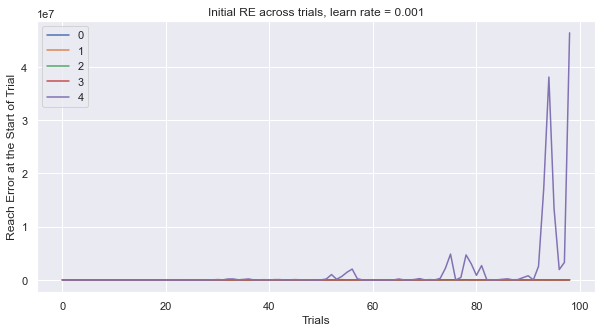

In [17]:
NUM_TRIALS = 100
NUM_RUNS = 2 # Has to be >1 # 2 = goes through the trail for target once
NUM_SESSIONS = 5
# rate_list = [5e-3, 1e-3, 5e-4, 1e-4]
rate_list = [1e-3]
A_RATE = 5e-5
K_RATE = 5e-5
ADAPT_TRIALS = NUM_TRIALS
ADAPT_DEC = False
KW_only = True

# initialization
cursor_start = np.zeros( (NUM_DIM, 1, NUM_TRIALS, NUM_SESSIONS) )
cursor_end = np.zeros( (NUM_DIM, 1, NUM_TRIALS, NUM_SESSIONS) )
target_trial = np.zeros( (NUM_DIM, 1, NUM_TRIALS, NUM_SESSIONS) )
lambda_trial = np.zeros( (NUM_NEURONS, NUM_LAMBDA, NUM_TRIALS, NUM_SESSIONS) )
fr_trial = np.zeros( (NUM_NEURONS, 1, NUM_TRIALS) )
a_trial = np.zeros( (NUM_DIM, NUM_TRIALS, NUM_SESSIONS) )
k_trial = np.zeros( (NUM_DIM, NUM_NEURONS, NUM_TRIALS, NUM_SESSIONS) )
re_startT = np.zeros( (NUM_TRIALS, NUM_SESSIONS) )
re_endT = np.zeros( (NUM_TRIALS, NUM_SESSIONS) )


for lambda_rate in rate_list:
    for iS in range(NUM_SESSIONS):
        print("")
        print("+++++++++++++++++++++++++++++++++++")
        print("Session #" + str(iS))
        ## BRAIN SIDE
        FR_DIST = (FR_SIGMA, FR_DELTA, FR_DIST_SIZE)
    #     fr_init[:, 0] = np.array(brainFiringRate(lambda_init, TARGET_VECTOR_ERR))

        ## DECODER SIDE
        A_DIST = (A_SIGMA, A_DELTA, A_DIST_SIZE)
        K_DIST = (K_SIGMA, K_DELTA, K_DIST_SIZE)

        # target position -- new target represents a new trial
        target_trial[:, :, 0, iS] = TARGET_VECTOR
        print("target at trial 0 = " + str(target_trial[:, :, 0, iS]))

        print("K MATX INIT= " + str(K_MATX))
        print("A VECT INIT = " + str(A_VECT))

        ## VECTORS FOR TRIALS    
        lambda_trial[:, :, 0, iS] = lambda_init
        print("lambda")
        print(lambda_trial[:, :, 0, iS])

        a_trial[:, 0, iS] = np.array(A_VECT)
        print("a")
        print(a_trial[:, 0, iS])

        k_trial[:,:, 0, iS] = K_MATX
        print("K")
        print(k_trial[:,:, 0, iS] )
        decoder_params = (a_trial[:, 0, iS], A_RATE, A_DIST, k_trial[:,:,  0, iS], K_RATE, K_DIST)
        decoder_vals = (A_VECT, K_MATX)
        

        for iT in range(NUM_TRIALS-1):
            print("")
            print("=========================================")
            print("Trial #" + str(iT) + " | lambda learn rate = " + str(lambda_rate))
            print("Target = " + str(target_trial[:, :, iT, iS]))

            # calculate firing rate given lambda and decoder parameters with current target position 
            fr_start = np.array(brainFiringRate(lambda_trial[:, :, iT, iS], target_trial[:, :, iT, iS]))
            fr_trial[:, :, iT] = fr_start
#             print("fr start of trial")
#             print(fr_start)
#             print("lambda start of trial")
#             print(lambda_trial[:, :, iT, iS])

            # calculate reach error of firing rate at the beginning of the trial
            # this becomes the error of the new target position being presented and where the cursor is
            brain_vars = ( fr_trial[:, :, iT],  target_trial[:, :, iT, iS] )
            cost_func_params = (decoder_vals, brain_vars) 
            
#             print("cost func params = "+ str(cost_func_params))
            re_startT[iT, iS] = error_costFunc(cost_func_params)
#             print("re start = " + str(re_startT[iT, iS]))

    #         (a_vect_in, k_matx_in) = decoder_params
            cursor_start[ :, :, iT, iS] =  (decoder_findY(decoder_vals, brain_vars))
#             print("cursor start = " + str(cursor_start[:, :, iT, iS]) )

            # Run through trial and see the reach at the end        
            # current brain and decoder params
            brain_params = (fr_trial[:, :, iT], FR_DIST, lambda_trial[:, :, iT, iS], lambda_rate)
            decoder_params = (a_trial[:, iT, iS], A_RATE, A_DIST, k_trial[:, :,  iT, iS], K_RATE, K_DIST)

            # adapt brain and decoder (together here)
            a_run, k_run = calcNextDecoder(decoder_params, brain_vars)
            if (KW_only):
                a_run = np.zeros((2, 1))
            fr_run, lambda_run = calcNextBrain(brain_params, decoder_params, target_trial[:, :, iT, iS], NUM_RUNS)
            
    #         print("fr_run = " + str(fr_run))
#             re_run, fr_run, lambda_run = brain_adapt_sgd(brain_params, decoder_params, target_trial[:, :, iT], NUM_RUNS)
            # update cost function arguments
            decoder_vals = (a_run, k_run)
            brain_vars = (fr_run, target_trial[:, :, iT, iS])
            # see how the updated decoder and brain paramters have done with the current
            # target position (so target at trial = iT)
            cost_func_params = (decoder_vals, brain_vars) 
            re_run = np.array(error_costFunc(cost_func_params))

            # So what are the end trial metrics?
            if (KW_only):
                lambda_run[:, 0] = 0
            cursor_end[:, :, iT, iS] =  (decoder_findY(decoder_vals, brain_vars))
#             print("fr end of trial = " + str(fr_run))
            print("lambda end of trial = " + str(lambda_run))
#             print("cursor end = " + str(cursor_end[:, :, iT, iS]) )

            re_endT[iT, iS] = re_run
#             print("re end = " + str(re_endT[iT, iS]))
#             print("re diff = " + str(re_endT[iT, iS] - re_startT[iT, iS]))

            # update the parameters
            lambda_trial[:, :, iT + 1, iS] = np.squeeze(lambda_run)
            a_trial[:, iT + 1, iS] = np.squeeze(a_run)
            k_trial[:, :, iT + 1, iS] = np.squeeze(k_run)
            print("a = " + str(a_trial[:, iT + 1, iS]))
            print("k = " + str(k_trial[:, :, iT + 1, iS]))

            # change to new target
            target_trial[:, 0, iT + 1, iS] = findNextTarget( cursor_end[:, :, iT, iS], target_trial[:, :, iT, iS] )
    
        # display stuff
#         print("target position:")
#         print(target_trial)
#         print("cursor end: ")
#         print(cursor_end)
#         print("cursor start: ")
#         print(cursor_start)

        
        pidx = rate_list.index(lambda_rate)
        plt.figure(2*pidx + 1, figsize=(fig_x, fig_y))
        plt.plot(np.arange(0, NUM_TRIALS-1, 1), re_startT[0:len(re_startT)-1, iS], label = '' + str(iS))
        plt.legend()
        plt.xlabel('Trials')
        plt.ylabel('Reach Error at the Start of Trial')
        plt.title('Initial RE across trials, learn rate = ' + str(lambda_rate))
        #     plt.show()
        
#         plt.figure(2*pidx + 2, figsize=(fig_x, fig_y))
#         plt.plot(np.arange(NUM_TRIALS-20-1, NUM_TRIALS-1, 1), re_startT[NUM_TRIALS-1-20:NUM_TRIALS-1, iS])
#         plt.xlabel('Trials' )#, color='white')
#         plt.ylabel('Reach Error at Last 20 Trials')#, color='white')
#         plt.title('Ending RE across trials | learn rate = ' + str(lambda_rate) + '| Decoder Adapt = ' + str(ADAPT_DEC)) #, color = 'white')
#         #     plt.show()

    

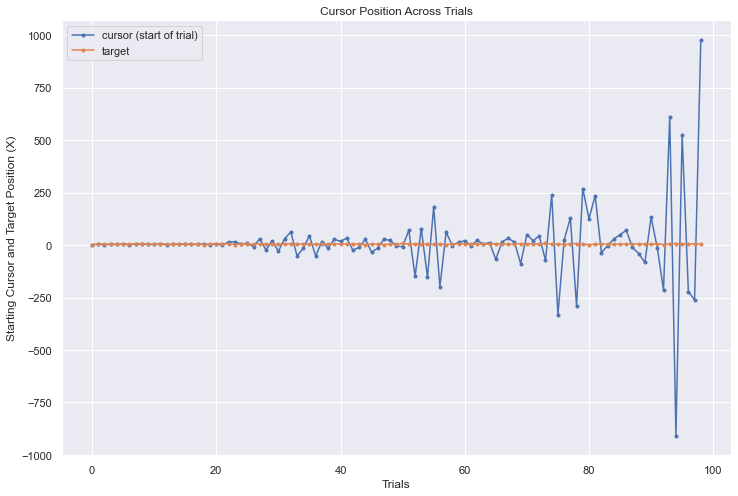

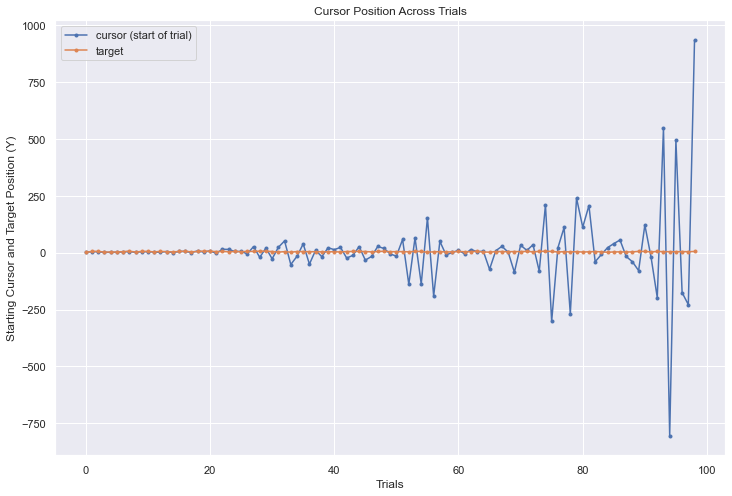

In [18]:
x = 0
y = 1

plt.figure(figsize = (12, 8))
start_x_mean = np.mean(cursor_start, axis=3)[x, 0, 0:NUM_TRIALS-1]
end_x_mean = np.mean(cursor_end, axis=3)[x, 0, 0:NUM_TRIALS-1]
start_y_mean = np.mean(cursor_start, axis=3)[y, 0, 0:NUM_TRIALS-1]
end_y_mean = np.mean(cursor_end, axis=3)[y, 0, 0:NUM_TRIALS-1]
targ_x_mean = np.mean(target_trial, axis=3)[x, 0, 0:NUM_TRIALS-1]
targ_y_mean = np.mean(target_trial, axis=3)[y, 0, 0:NUM_TRIALS-1]

plt.plot(start_x_mean, linestyle = '-', marker = '.', label = 'cursor (start of trial)')
plt.plot(targ_x_mean, linestyle = '-', marker = '.', label = 'target' )
plt.legend()
plt.xlabel('Trials')
plt.ylabel('Starting Cursor and Target Position (X)')
plt.title('Cursor Position Across Trials')
plt.show()


# plt.figure(figsize = (12, 8))
# plt.plot(np.arange(0, NUM_TRIALS, 1), end_x_mean, linestyle = '-', marker = '.', label = 'cursor (end of trial)')
# plt.plot(np.arange(0, NUM_TRIALS, 1), targ_x_mean, linestyle = '-', marker = '.', label = 'target' )
# plt.legend()
# plt.xlabel('Trials')
# plt.ylabel('Ending Cursor and Target Position (X)')
# plt.title('Cursor Position Across Trials')
# plt.show()

plt.figure(figsize = (12, 8))
plt.plot(start_y_mean, linestyle = '-', marker = '.', label = 'cursor (start of trial)')
plt.plot(targ_y_mean, linestyle = '-', marker = '.', label = 'target' )
plt.legend()
plt.xlabel('Trials')
plt.ylabel('Starting Cursor and Target Position (Y)')
plt.title('Cursor Position Across Trials')
plt.show()

# plt.figure(figsize = (12, 8))
# plt.plot(np.arange(0, NUM_TRIALS, 1), end_y_mean, linestyle = '-', marker = '.', label = 'cursor (end of trial)')
# plt.plot(np.arange(0, NUM_TRIALS, 1), targ_y_mean, linestyle = '-', marker = '.', label = 'target' )
# plt.legend()
# plt.xlabel('Trials')
# plt.ylabel('Ending Cursor and Target Position (Y)')
# plt.title('Cursor Position Across Trials')
# plt.show()

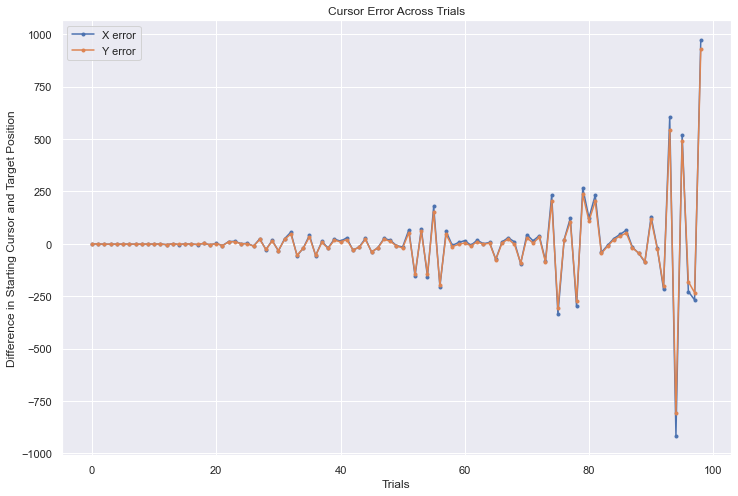

In [19]:
plt.figure(figsize = (12, 8))
plt.plot(start_x_mean - targ_x_mean, linestyle = '-', marker = '.', label = 'X error')
plt.plot(start_y_mean - targ_y_mean, linestyle = '-', marker = '.', label = 'Y error' )
plt.legend()
plt.xlabel('Trials')
plt.ylabel('Difference in Starting Cursor and Target Position')
plt.title('Cursor Error Across Trials')
plt.show()

Text(0.5, 1.0, 'Mean KW Matrix (1,1)')

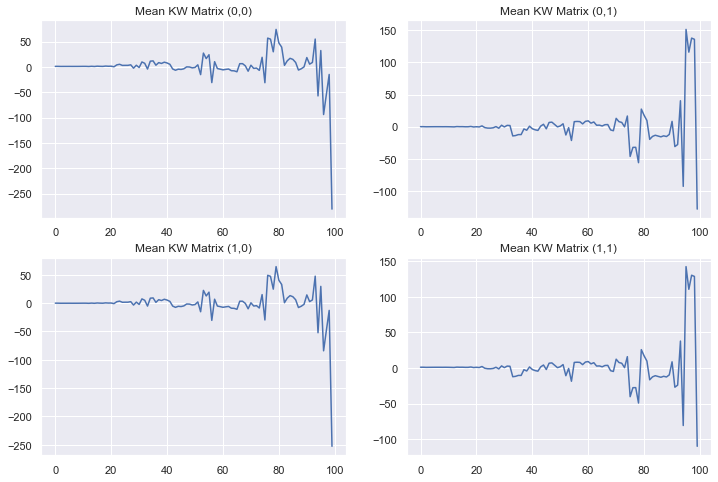

In [20]:
# print(np.shape(lambda_trial))
# print(np.shape(k_trial))
# print(np.shape((k_trial[:, :,1])))
# print(np.shape((lambda_trial[:, 1:3, 1])))

lk_mtx = np.zeros((NUM_DIM, NUM_DIM, NUM_TRIALS))
lk_mtx_temp = np.zeros((NUM_DIM, NUM_DIM, NUM_TRIALS, NUM_SESSIONS))
# print(np.shape((k_trial[:,:, :, 1])))
# print((lambda_trial[:, 1:3, 1, 1]))
for iT in range(NUM_TRIALS):
    for iS in range(NUM_SESSIONS):
        lk_mtx_temp[:,:, iT, iS] = np.matmul(k_trial[:,:, iT, iS], lambda_trial[:, 1:3, iT, iS])
    lk_mtx = np.mean(lk_mtx_temp[:,:, :, :], axis=3)

 
plt.figure(figsize = (12, 8))
plt.subplot(221)
plt.plot(lk_mtx[0, 0, :])
plt.title("Mean KW Matrix (0,0)")

plt.subplot(222)
plt.plot(lk_mtx[0, 1, :])
plt.title("Mean KW Matrix (0,1)")

plt.subplot(223)
plt.plot(lk_mtx[1, 0, :])
plt.title("Mean KW Matrix (1,0)")

plt.subplot(224)
plt.plot(lk_mtx[1, 1, :])
plt.title("Mean KW Matrix (1,1)")


Text(0.5, 1.0, 'Mean KW Matrix (1,1) | Last 100 Trials ')

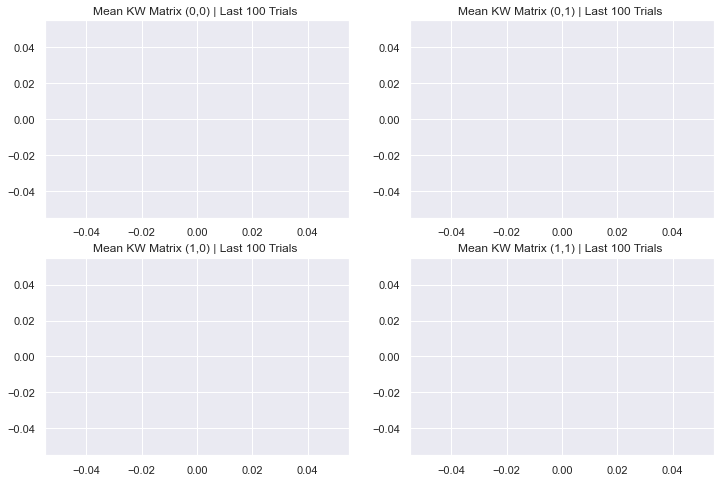

In [21]:

plt.figure(figsize = (12, 8))
plt.subplot(221)
plt.plot(lk_mtx[0, 0, NUM_TRIALS-1-100:NUM_TRIALS-1])
plt.title("Mean KW Matrix (0,0) | Last 100 Trials ")

plt.subplot(222)
plt.plot(lk_mtx[0, 1,  NUM_TRIALS-1-100:NUM_TRIALS-1])
plt.title("Mean KW Matrix (0,1) | Last 100 Trials ")

plt.subplot(223)
plt.plot(lk_mtx[1, 0,  NUM_TRIALS-1-100:NUM_TRIALS-1])
plt.title("Mean KW Matrix (1,0) | Last 100 Trials ")

plt.subplot(224)
plt.plot(lk_mtx[1, 1,  NUM_TRIALS-1-100:NUM_TRIALS-1])
plt.title("Mean KW Matrix (1,1) | Last 100 Trials ")


In [22]:
print("Average Reach Error Per Session:")

for iS in range(NUM_SESSIONS):
    print("Session # " + str(iS) + "| RE = " + str(np.mean(re_startT[:, iS])))

Average Reach Error Per Session:
Session # 0| RE = 83.97750996494906
Session # 1| RE = 3516.92053023774
Session # 2| RE = 27.64125266050095
Session # 3| RE = 2856.306449635987
Session # 4| RE = 1511672.0383731013
